In [ ]:
# !pip install sentinelhub
# !pip install geopandas
# !pip3 install eo-learn
# !pip install eo-learn[VISUALIZATION]
# !pip install matplotlib
# !pip install imageio

In [26]:
from helper import *

In [27]:
# This is script may only work with sentinelhub.__version__ >= '3.4.0'
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry, SentinelHubDownloadClient, generate_evalscript
from eolearn.io import get_available_timestamps,SentinelHubInputTask,SentinelHubEvalscriptTask
# from sentinelhub import CRS, BBox, DataCollection, SHConfig
from eolearn.core import EOWorkflow, FeatureType, LoadTask, OutputTask, SaveTask, linearly_connect_tasks
import datetime
import matplotlib.pyplot as plt


# # Credentials
config1= SHConfig()
config1.sh_client_id = 'sh_client_id'
config1.sh_client_secret = 'sh_client_secret'
config1.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config1.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [28]:
def generate_eopatch_for_band(city, band, bbox, timeinterval):
    time_difference = datetime.timedelta(days=1)
    maxcc = 0.8
    
    # gets the snapshots available dates
    picked = get_available_timestamps(
        bbox=bbox,
        data_collection=DataCollection.SENTINEL5P.define_from(name="sentinel-5p-l2",service_url=config1.sh_base_url),
        time_interval=timeinterval,
        time_difference=time_difference,
        maxcc=maxcc,
        config=config1
    )
    
    # max and min snapshot dates
    time_interval_series = (picked[0], picked[-1])
    
    # creating eval scripts to download particular band
    evall = generate_evalscript(
        data_collection=DataCollection.SENTINEL5P.define_from(name="sentinel-5p-l2",service_url=config1.sh_base_url),
        bands=[band]
    )
    
    # creating the task to download data from SH
    input_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band)], 
        data_collection=DataCollection.SENTINEL5P.define_from(name="sentinel-5p-l2",service_url=config1.sh_base_url),
        evalscript=evall,
        resolution=1000,
        maxcc=maxcc,
        time_difference=time_difference,
        config=config1
    )
    
    save = SaveTask("p5")
    output_task = OutputTask("eopatch")
    
    workflow_nodes = linearly_connect_tasks(input_task, save, output_task)
    workflow = EOWorkflow(workflow_nodes)
    
    result = workflow.execute(
        {
            workflow_nodes[0]: {"bbox": bbox, "time_interval": time_interval},
            workflow_nodes[1]: {"eopatch_folder": city},
        }
    )
    
def multi_bands_eopatch(city, bands, bbox, timeinterval):
    for band in bands: 
        generate_eopatch_for_band(city, band, bbox, timeinterval)

In [29]:
components = ["O3", "SO2", "NO2", "CO", "AER_AI_354_388"]
time_interval = ("2024-10-28", "2024-11-03")

In [34]:
chennai_outline = gpd.read_file("geojsons/hyderabad.geojson")
outline_bbox = get_bbox(chennai_outline)

In [36]:
multi_bands_eopatch("hyderabad", components, outline_bbox, time_interval)

In [37]:
chennai_eopatch = EOPatch.load("p5/hyderabad")

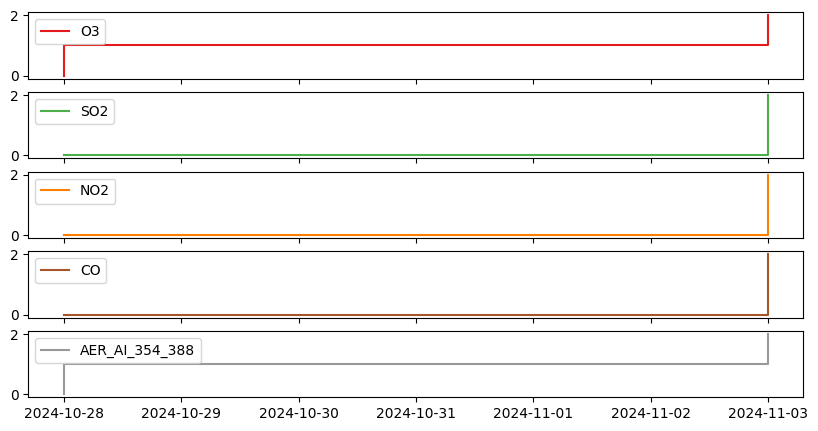

In [38]:
aqi_for_patch(chennai_eopatch)

In [39]:
aqi_for_patch_for_date(chennai_eopatch,0)

Ozone Concentration is ModerateSulfur dioxide Concentration is GoodNitrogen dioxide Concentration is GoodCarbon monoxide Concentration is GoodAerosol Concentration is Moderate
